### Importa dependencias

In [1]:
# importar dependencias
import streamlit as st # web development
import numpy as np # np mean, np random 
import pandas as pd # read csv, df manipulation
import time # to simulate a real time data, time loop 
import plotly.express as px # interactive charts
from streamlit_autorefresh import st_autorefresh
from datetime import datetime, time, timedelta, date, timezone
from time import sleep
from pymysql import connect
import os
import dotenv
from textwrap import dedent
from millify import millify, prettify

### Carga datos almacenados por la app

#### Llamadas en la ventana de consulta

In [2]:
df = pd.read_csv('/home/cgorricho/apps/200eng_sim/df_llamadas.csv')
df.starttime = pd.to_datetime(df.starttime)
df.calledstation = df.calledstation.astype('category')
df.real_sessiontime = df.real_sessiontime.astype('int')
df.bd = df.bd.astype('category')
df = df.set_index('starttime')
df

,calledstation,real_sessiontime,bd,weekday,hour
starttime,,,,,
2024-10-22 18:03:47,18772940683,41,marcador_1,1,18
2024-10-22 18:05:28,18885651645,12,marcador_1,1,18
2024-10-22 18:06:09,18007249521,13,marcador_1,1,18
2024-10-25 16:27:05,18886285041,152,marcador_1,4,16
2024-10-25 16:27:17,18007430542,14,marcador_1,4,16
...,...,...,...,...,...
2024-11-25 21:18:06,18888867279,40,marcador_2,0,21
2024-11-25 21:18:25,18338623935,1752,marcador_2,0,21
2024-11-25 21:18:46,18336591916,146,marcador_2,0,21


In [3]:
df.bd.nunique()

2

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 489788 entries, 2024-10-22 18:03:47 to 2024-11-25 21:19:23
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   calledstation     489788 non-null  category
 1   real_sessiontime  489788 non-null  int64   
 2   bd                489788 non-null  category
 3   weekday           489788 non-null  int64   
 4   hour              489788 non-null  int64   
dtypes: category(2), int64(3)
memory usage: 19.9 MB


Reorganización de las llamadas por horas:
* Resampling del indice
* Número total de llamadas cada hora
* Segundos totales cada hora

In [5]:
# Resample to hourly intervals and calculate the total calls and total call duration
hourly_summary = df.resample('h').agg(
    total_calls=('calledstation', 'size'),          # Count of calls
    total_call_duration=('real_sessiontime', 'sum') # Sum of call duration
)

hourly_summary['avg_call_duration'] = hourly_summary.total_call_duration / hourly_summary.total_calls

hourly_summary

,total_calls,total_call_duration,avg_call_duration
starttime,,,
2024-10-22 18:00:00,3,66,22.000000
2024-10-22 19:00:00,0,0,NaN
2024-10-22 20:00:00,0,0,NaN
2024-10-22 21:00:00,0,0,NaN
2024-10-22 22:00:00,0,0,NaN
...,...,...,...
2024-11-25 17:00:00,4806,1899500,395.235123
2024-11-25 18:00:00,4816,1797988,373.336379
2024-11-25 19:00:00,2762,962803,348.589066


<Axes: xlabel='starttime'>

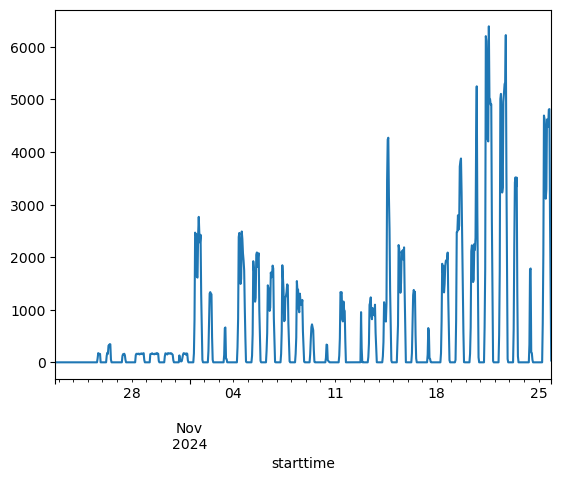

In [6]:
%matplotlib inline
hourly_summary.total_calls.plot()

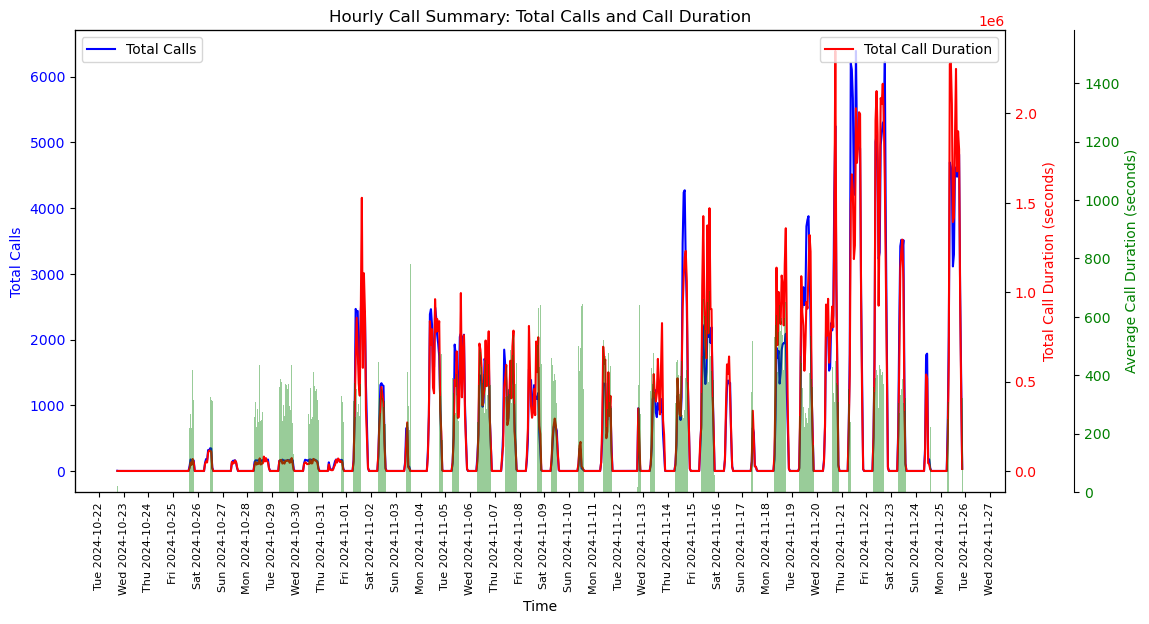

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming hourly_summary is your DataFrame with 'total_calls' and 'total_call_duration'
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot total calls on the left y-axis
ax1.plot(hourly_summary.index, hourly_summary['total_calls'], color='blue', label='Total Calls')
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Calls', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Set x-axis to display only daily intervals with full date formatting
ax1.xaxis.set_major_locator(mdates.DayLocator())  # Show ticks at the start of each day
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %Y-%m-%d'))  # Format as year-month-day

plt.xticks(rotation=90, fontsize=8)

# Create a second y-axis for total call duration
ax2 = ax1.twinx()
ax2.plot(hourly_summary.index, hourly_summary['total_call_duration'], color='red', label='Total Call Duration')
ax2.set_ylabel('Total Call Duration (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Create a third y-axis for total call duration
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 50))
ax3.bar(hourly_summary.index, hourly_summary['avg_call_duration'], color='green', label='Avergae Call Duration', width=0.025, alpha=0.4)
ax3.set_ylabel('Average Call Duration (seconds)', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set title
plt.title('Hourly Call Summary: Total Calls and Call Duration')

# Show plot
plt.show()


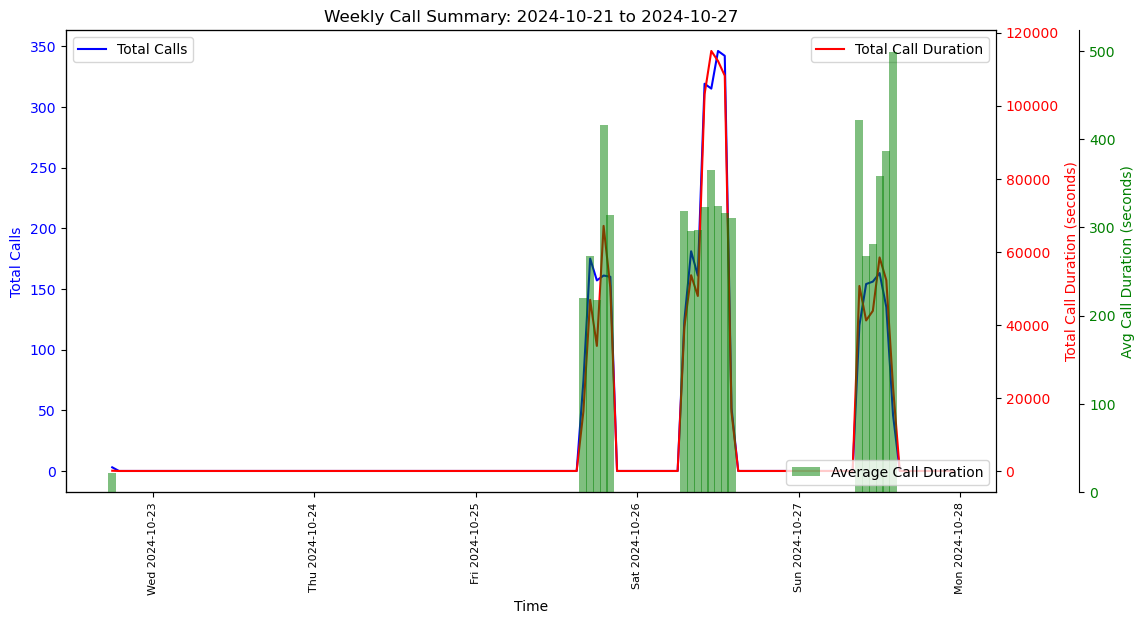

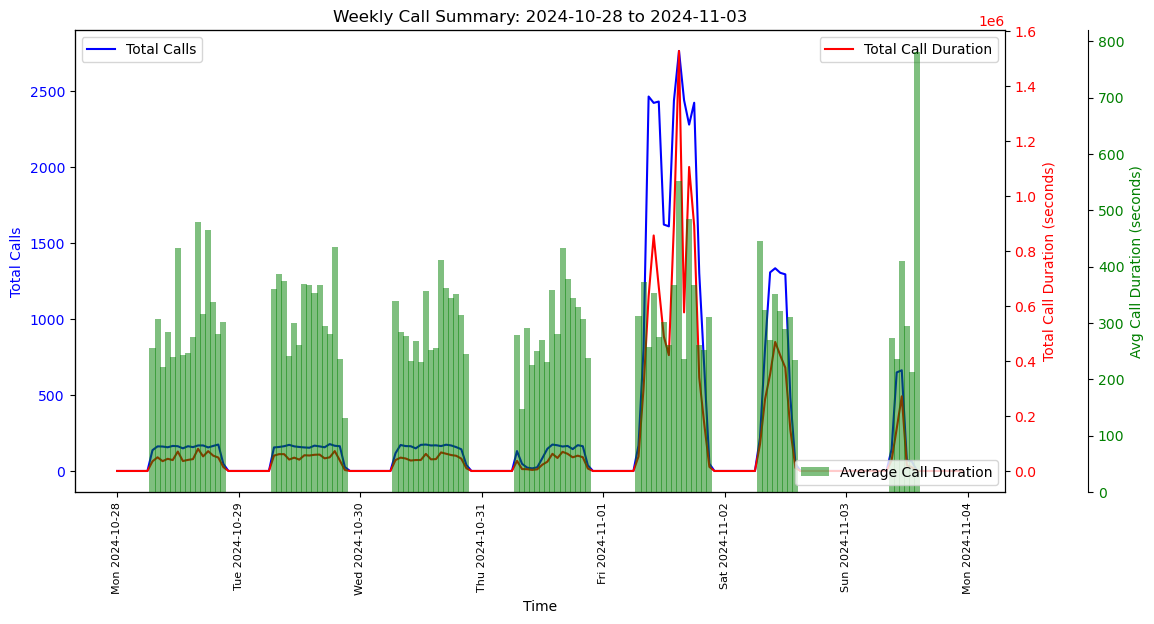

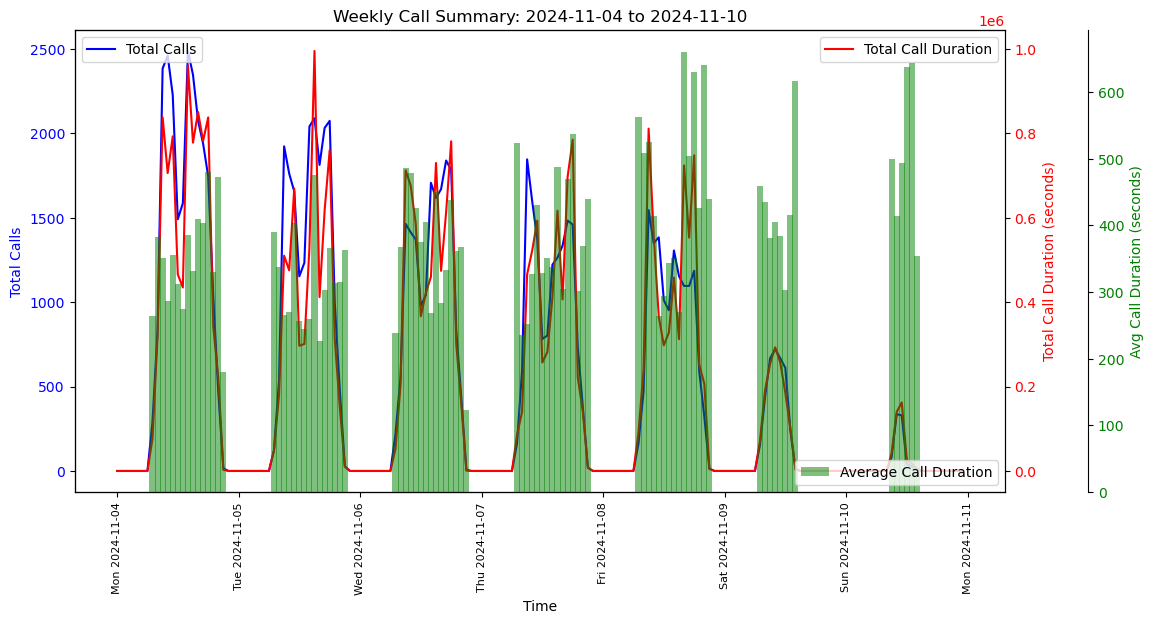

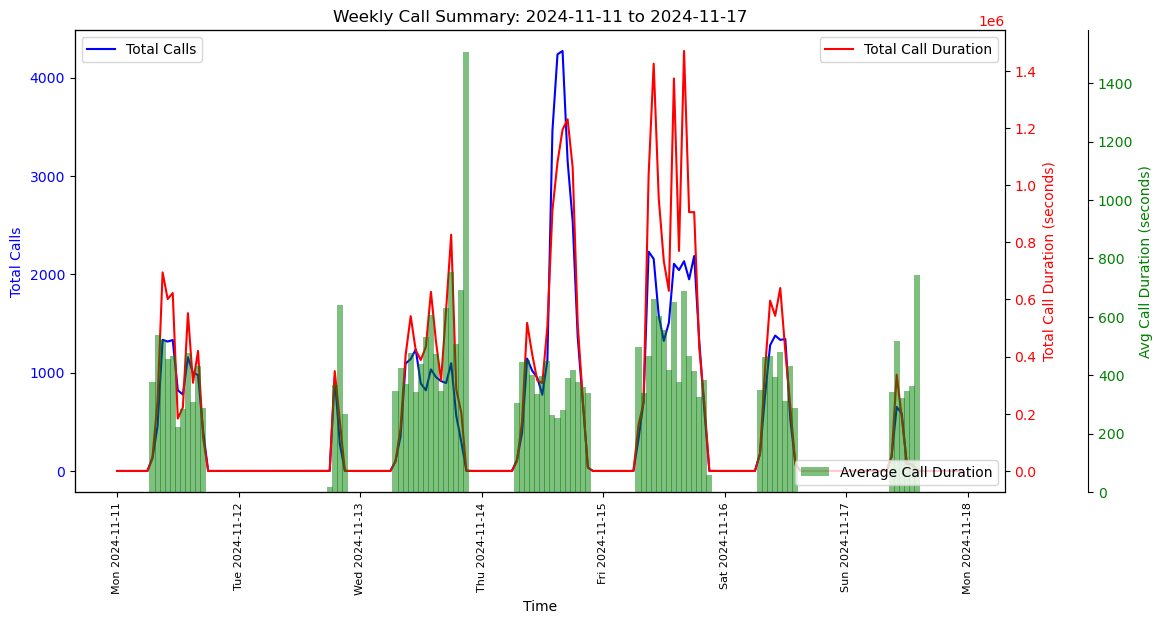

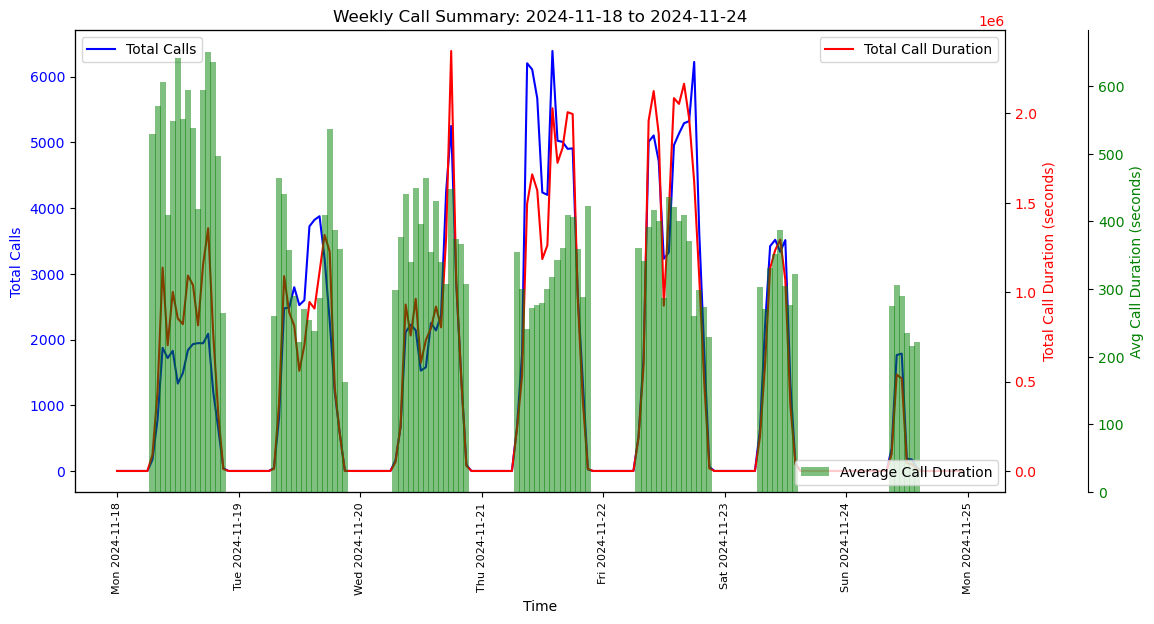

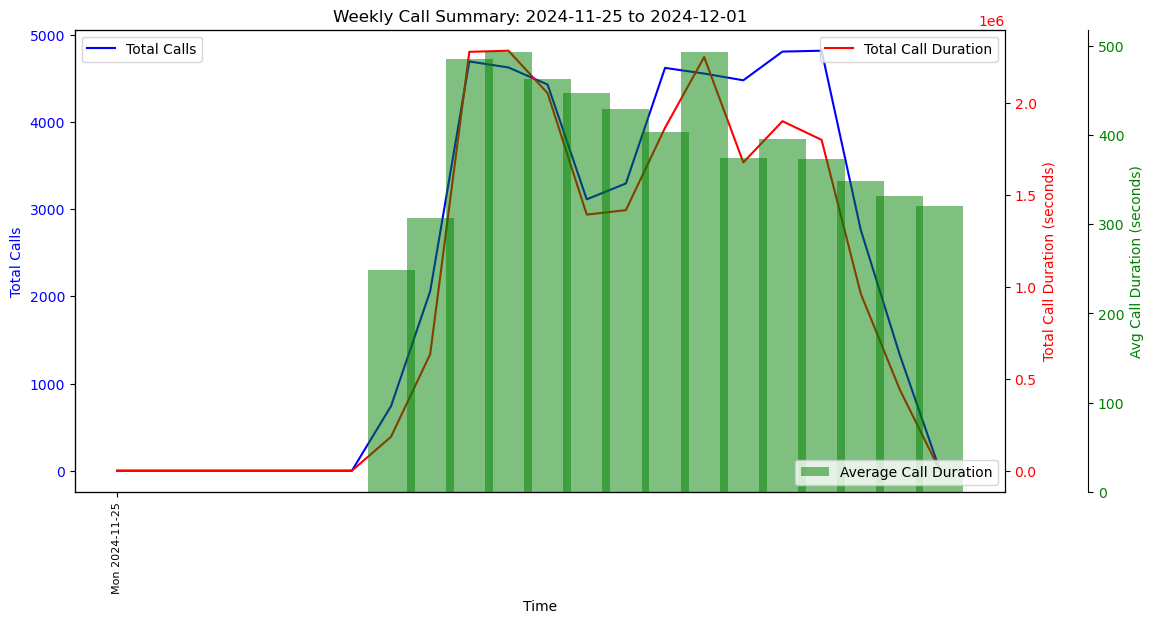

In [8]:
# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'hourly_summary' already exists and contains the 'avg_call_duration' column

# Set the index to be a DatetimeIndex if it isn't already
hourly_summary.index = pd.to_datetime(hourly_summary.index)

# Resample data into weekly periods starting on Monday
hourly_summary['week'] = hourly_summary.index.to_period('W-SUN')

# Loop through each week in the data and plot it
for week, week_data in hourly_summary.groupby('week'):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot total calls on the left y-axis
    ax1.plot(week_data.index, week_data['total_calls'], color='blue', label='Total Calls')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Total Calls', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Set x-axis to display only daily intervals with full date formatting and three-letter weekday
    ax1.xaxis.set_major_locator(mdates.DayLocator())  # Show ticks at the start of each day
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %Y-%m-%d'))  # Include 3-letter weekday

    # Rotate x-axis labels for better readability and make font size smaller
    plt.xticks(rotation=90, fontsize=8)

    # Create a second y-axis for total call duration
    ax2 = ax1.twinx()
    ax2.plot(week_data.index, week_data['total_call_duration'], color='red', label='Total Call Duration')
    ax2.set_ylabel('Total Call Duration (seconds)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Create a third y-axis for average call duration
    ax3 = ax1.twinx()
    # Offset the third y-axis so it does not overlap with the second y-axis
    ax3.spines['right'].set_position(('outward', 60))
    ax3.bar(week_data.index, week_data['avg_call_duration'], color='green', label='Average Call Duration', width=0.05, alpha=0.5)
    ax3.set_ylabel('Avg Call Duration (seconds)', color='green')
    ax3.tick_params(axis='y', labelcolor='green')

    # Add legends for all three axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax3.legend(loc='lower right')

    # Set title
    plt.title(f'Weekly Call Summary: {week.start_time.strftime("%Y-%m-%d")} to {week.end_time.strftime("%Y-%m-%d")}')

    # Show plot
    plt.show()


#### Números de destino en la ventana de consulta

In [9]:
df_dest = pd.read_csv('df_dest.csv')
df_dest

,calledstation,real_sessiontime,num_llamadas,dur_prom,std_lst_2,mean_lst_2,flat_ratio
0,18005562161,27568,17,1621.647059,1307.440438,2676.5,0.488489
1,18665848885,6537,17,384.529412,558.614357,445.0,1.255313
2,18772055548,31715,16,1982.187500,1470.782105,2547.0,0.577457
3,18778894546,31511,16,1969.437500,1231.072906,2729.5,0.451025
4,18777769953,31494,16,1968.375000,1815.850214,2315.0,0.784385
...,...,...,...,...,...,...,...
72323,18556555331,2,1,2.000000,NaN,2.0,NaN
72324,18883120444,2,1,2.000000,NaN,2.0,NaN
72325,18778484062,2,1,2.000000,NaN,2.0,NaN
72326,18772663403,2,1,2.000000,NaN,2.0,NaN


In [10]:
df_dest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72328 entries, 0 to 72327
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   calledstation     72328 non-null  int64  
 1   real_sessiontime  72328 non-null  int64  
 2   num_llamadas      72328 non-null  int64  
 3   dur_prom          72328 non-null  float64
 4   std_lst_2         71801 non-null  float64
 5   mean_lst_2        72328 non-null  float64
 6   flat_ratio        71801 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 3.9 MB


Compara suma de duraciones de llamadas de df vs df_dest

In [11]:
df_dest.real_sessiontime.sum() == df.real_sessiontime.sum()

True

#### Numeros de destino con línea plana
* 2 llamadas con flat ratio <= 0.005

In [12]:
df_dest_flat = pd.read_csv('df_dest_flat.csv')
df_dest_flat

,calledstation,real_sessiontime,num_llamadas,dur_prom,std_lst_2,mean_lst_2,flat_ratio
0,18004527171,23355,16,1459.687500,1.414214,598.0,0.002365
1,18665326440,20779,16,1298.687500,0.000000,1848.0,0.000000
2,18006249168,12863,16,803.937500,0.707107,1199.5,0.000590
3,18446440474,23912,15,1594.133333,2.828427,1332.0,0.002123
4,18882618867,23715,15,1581.000000,0.707107,1841.5,0.000384
...,...,...,...,...,...,...,...
29198,18664544991,4,2,2.000000,0.000000,2.0,0.000000
29199,18008309713,4,2,2.000000,0.000000,2.0,0.000000
29200,18009854704,4,2,2.000000,0.000000,2.0,0.000000
29201,18883157618,4,2,2.000000,0.000000,2.0,0.000000


##### Numeros con línea plana y flat ratio <= 0.0015

In [13]:
df_dest_flat_0015 = df_dest_flat[df_dest_flat.flat_ratio <= 0.0015]
df_dest_flat_0015

,calledstation,real_sessiontime,num_llamadas,dur_prom,std_lst_2,mean_lst_2,flat_ratio
1,18665326440,20779,16,1298.687500,0.000000,1848.0,0.000000
2,18006249168,12863,16,803.937500,0.707107,1199.5,0.000590
4,18882618867,23715,15,1581.000000,0.707107,1841.5,0.000384
5,18004375288,23027,15,1535.133333,0.707107,1756.5,0.000403
6,18552083575,21979,15,1465.266667,1.414214,1811.0,0.000781
...,...,...,...,...,...,...,...
29198,18664544991,4,2,2.000000,0.000000,2.0,0.000000
29199,18008309713,4,2,2.000000,0.000000,2.0,0.000000
29200,18009854704,4,2,2.000000,0.000000,2.0,0.000000
29201,18883157618,4,2,2.000000,0.000000,2.0,0.000000


##### Números con línea plana y flat ratio == 0

In [14]:
df_dest_flat_0 = df_dest_flat[df_dest_flat.flat_ratio == 0.0]
df_dest_flat_0

,calledstation,real_sessiontime,num_llamadas,dur_prom,std_lst_2,mean_lst_2,flat_ratio
1,18665326440,20779,16,1298.687500,0.0,1848.0,0.0
8,18882291919,20598,15,1373.200000,0.0,1799.0,0.0
11,18442924211,14706,15,980.400000,0.0,16.0,0.0
12,18772111938,14551,15,970.066667,0.0,44.0,0.0
16,18664833738,11138,15,742.533333,0.0,121.0,0.0
...,...,...,...,...,...,...,...
29198,18664544991,4,2,2.000000,0.0,2.0,0.0
29199,18008309713,4,2,2.000000,0.0,2.0,0.0
29200,18009854704,4,2,2.000000,0.0,2.0,0.0
29201,18883157618,4,2,2.000000,0.0,2.0,0.0


##### Números con línea plana y duración promedio de las 2 últimas llamadas >= 3,500 segundos

In [15]:
df_dest_flat_3500 = df_dest_flat[df_dest_flat.mean_lst_2 >= 3500]
df_dest_flat_3500

,calledstation,real_sessiontime,num_llamadas,dur_prom,std_lst_2,mean_lst_2,flat_ratio


##### % de facturación sobre facturación total

In [16]:
df_dest_flat_3500.real_sessiontime.sum() / df.real_sessiontime.sum() 

0.0

### Visualizaciones

##### Distribución de duraciones promedio num dest con línea plana

<Axes: >

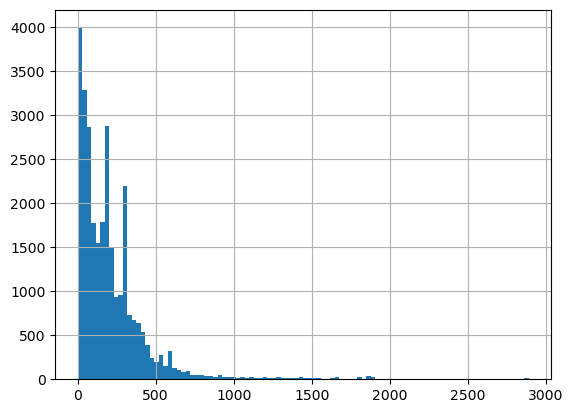

In [17]:
df_dest_flat.dur_prom.hist(bins=100, )

##### Histograma de duración promedio last 2 en num dest con línea plana

<Axes: >

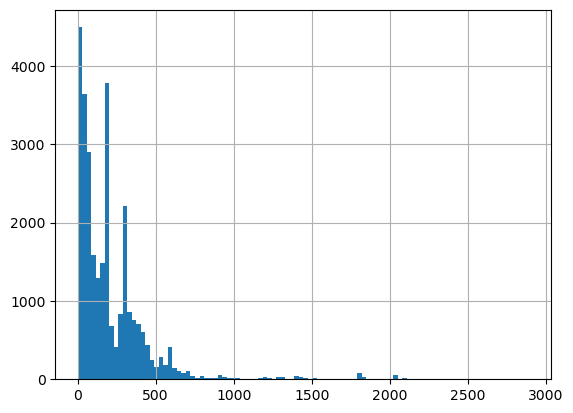

In [18]:
df_dest_flat.mean_lst_2.hist(bins=100)

##### Histograma de duraciones promedio de todos los números de destino

<Axes: >

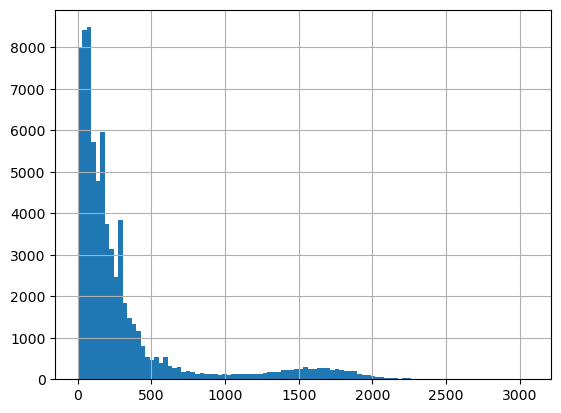

In [19]:
df_dest.dur_prom.hist(bins=100)

##### Histograma de duración promedio last 2 en num dest con línea plana

<Axes: >

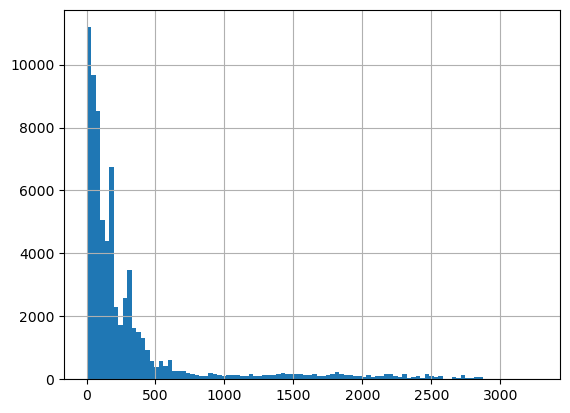

In [20]:
df_dest.mean_lst_2.hist(bins=100)

##### Histograma de duraciones en df

<Axes: >

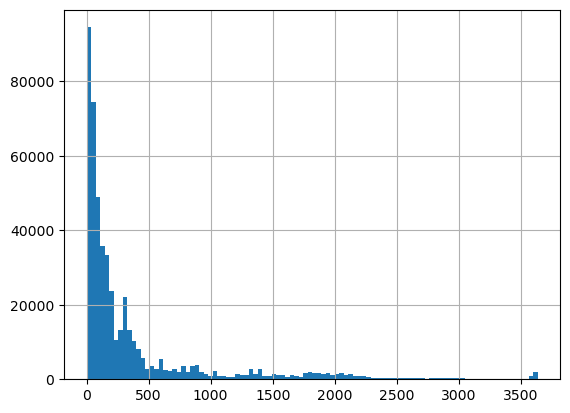

In [21]:
df.real_sessiontime.hist(bins=100)